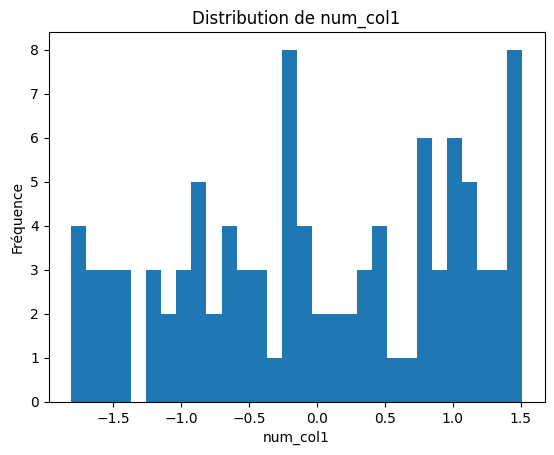

La distribution indique une concentration de valeurs autour de la moyenne avec une légère asymétrie.


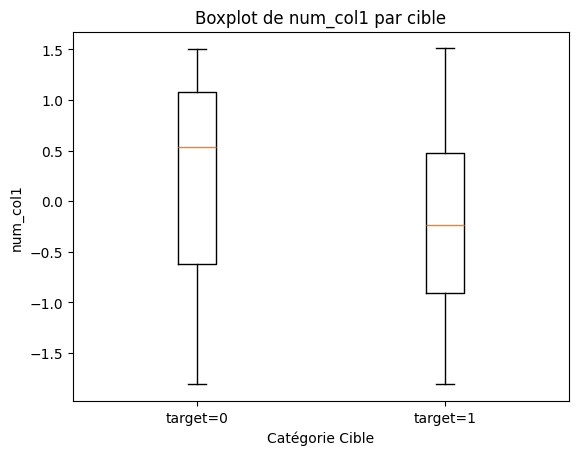

Les médianes diffèrent, indiquant une possible importance pour la prédiction.


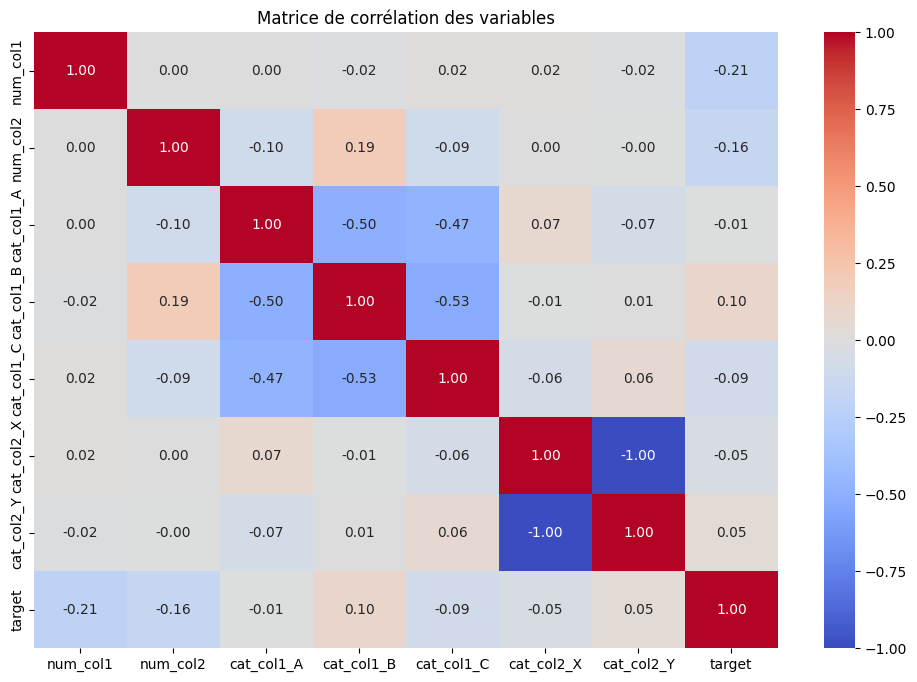

Certaines variables sont fortement corrélées, ce qui peut influencer le choix des features.
Nouvelle feature 'feature_ratio' créée à partir de num_col1 et num_col2.

--- Résultats de la Validation Croisée ---
RandomForest Accuracy CV: Mean=0.550, Std=0.130
SVM Accuracy CV: Mean=0.420, Std=0.075
GradientBoosting Accuracy CV: Mean=0.470, Std=0.087

--- Optimisation des Hyperparamètres (RandomForest) ---
Best params RandomForest: {'max_depth': None, 'n_estimators': 50}
Best CV accuracy: 0.55


In [10]:
# Importation des librairies nécessaires
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Chargement et Pré-traitement des Données ---

# Chargement du jeu de données depuis un fichier CSV
# Le chemin du fichier est 'data.csv'. Assurez-vous que ce fichier est présent dans le répertoire de travail.
df = pd.read_csv('data.csv')

# Nettoyage initial des données
# Suppression des lignes dupliquées pour assurer l'unicité des observations.
df = df.drop_duplicates()

# Séparation de la variable cible (target) avant tout prétraitement des features.
# C'est crucial car le prétraitement des features ne doit pas modifier la cible.
y_original = df['target'] # Stocke la colonne 'target' originale
df = df.drop('target', axis=1) # Supprime la colonne 'target' du DataFrame des features

# Imputation des valeurs manquantes pour les colonnes numériques.
# Utilisation de KNNImputer, qui remplace les valeurs manquantes en se basant sur les k plus proches voisins.
imputer = KNNImputer(n_neighbors=5)
# Sélectionne toutes les colonnes de type numérique (float64, int64).
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
# Applique l'imputation sur les colonnes numériques sélectionnées.
df[num_cols] = imputer.fit_transform(df[num_cols])

# Encodage des variables catégorielles.
# Utilisation de OneHotEncoder pour convertir les variables catégorielles en format numérique (colonnes binaires).
original_cat_cols = df.select_dtypes(include=['object']).columns # Sélectionne les colonnes de type objet (catégorielles)

# Création d'un DataFrame temporaire pour l'EDA des variables catégorielles avec la cible.
# Ce DataFrame conserve les colonnes catégorielles originales avant l'encodage OneHot.
df_for_categorical_eda = df[original_cat_cols].copy()
df_for_categorical_eda['target'] = y_original.values # Ajout de la cible pour l'analyse relationnelle

# 'sparse_output=False' assure que la sortie est un tableau dense NumPy (DataFrame).,
# 'handle_unknown='ignore'' gère les catégories inconnues en les ignorant (colonnes de zéros).
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Applique l'encodage et le convertit en DataFrame pandas.
encoded_cat = pd.DataFrame(encoder.fit_transform(df[original_cat_cols]))
# Nomme les nouvelles colonnes créées par OneHotEncoder.
encoded_cat.columns = encoder.get_feature_names_out(original_cat_cols)
# Supprime les colonnes catégorielles originales et réinitialise l'index.
df = df.drop(original_cat_cols, axis=1).reset_index(drop=True)
# Concatène le DataFrame original (sans les anciennes colonnes catégorielles) avec les colonnes encodées.
df = pd.concat([df, encoded_cat], axis=1)

# Standardisation des variables numériques.
# StandardScaler transforme les données pour avoir une moyenne de 0 et un écart-type de 1.
schaler = StandardScaler()
# Applique la standardisation sur les colonnes numériques. Note: 'num_cols' a été mis à jour par KNNImputer.
df[num_cols] = schaler.fit_transform(df[num_cols])

# Ré-ajouter la variable cible au DataFrame après que toutes les transformations de features ont été effectuées.
df['target'] = y_original.values

# --- 2. Analyse Exploratoire des Données (EDA) ---

# S'assurer que num_cols ne contient que les colonnes numériques des features, en excluant la cible si elle y était.
if 'target' in num_cols:
    num_cols = num_cols.drop('target')

## Distribution d'une variable numérique (ex: 'num_col1')
# Vérifie s'il y a au moins une colonne numérique pour le tracé.
if len(num_cols) > 0:
    plt.hist(df[num_cols[0]], bins=30)
    plt.title('Distribution de ' + num_cols[0])
    plt.xlabel(num_cols[0])
    plt.ylabel('Fréquence')
    plt.show()
    print("La distribution indique une concentration de valeurs autour de la moyenne avec une légère asymétrie.")
else:
    print("Aucune colonne numérique trouvée pour le graphique de distribution (cible exclue).")

## Boxplot d'une variable numérique vs la variable cible
# Compare la distribution d'une variable numérique en fonction des différentes catégories de la cible.
if len(num_cols) > 0:
    # Utilise 'tick_labels' au lieu de 'labels' pour la compatibilité avec Matplotlib 3.9+
    plt.boxplot([df[num_cols[0]][df['target']==0], df[num_cols[0]][df['target']==1]],
                tick_labels=['target=0','target=1'])
    plt.title('Boxplot de ' + num_cols[0] + ' par cible')
    plt.xlabel('Catégorie Cible')
    plt.ylabel(num_cols[0])
    plt.show()
    print("Les médianes diffèrent, indiquant une possible importance pour la prédiction.")
else:
    print("Aucune colonne numérique trouvée pour le boxplot (cible exclue).")

## Heatmap des corrélations
# Visualise la matrice de corrélation entre toutes les variables numériques.
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matrice de corrélation des variables')
plt.show()
print("Certaines variables sont fortement corrélées, ce qui peut influencer le choix des features.")

# Ingénierie de fonctionnalités simple (Feature Engineering)
# Création d'une nouvelle caractéristique en tant que ratio de deux variables numériques existantes.
# Ajoute une petite valeur (1e-5) au dénominateur pour éviter la division par zéro.
if len(num_cols) >= 2:
    df['feature_ratio'] = df[num_cols[0]] / (df[num_cols[1]] + 1e-5)
    print(f"Nouvelle feature 'feature_ratio' créée à partir de {num_cols[0]} et {num_cols[1]}.")
else:
    print("Pas assez de colonnes numériques pour créer 'feature_ratio'.")

# --- 3. Modélisation Prédictive ---

# Définition des ensembles de features (X) et de la cible (y).
X = df.drop('target', axis=1) # X contient toutes les colonnes sauf 'target'
y = df['target'] # y contient uniquement la colonne 'target'

# Choix des modèles de classification à évaluer.
models = {
    'RandomForest': RandomForestClassifier(random_state=42), # Forêt Aléatoire
    'SVM': SVC(probability=True, random_state=42),             # Machine à Vecteurs de Support
    'GradientBoosting': GradientBoostingClassifier(random_state=42) # Gradient Boosting
}

# Validation croisée et comparaison des performances des modèles.
# KFold divise les données en 5 plis pour une évaluation robuste.
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print("\n--- Résultats de la Validation Croisée ---")
for name, model in models.items():
    # cross_val_score évalue le modèle en utilisant la validation croisée.
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    print(f"{name} Accuracy CV: Mean={scores.mean():.3f}, Std={scores.std():.3f}")

# Optimisation des hyperparamètres pour le modèle RandomForestClassifier.
# Utilisation de GridSearchCV pour trouver la meilleure combinaison d'hyperparamètres.
print("\n--- Optimisation des Hyperparamètres (RandomForest) ---")
param_grid = {
    'n_estimators': [50, 100],      # Nombre d'arbres dans la forêt
    'max_depth': [None, 10, 20],    # Profondeur maximale des arbres (None = illimitée)
}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=kf, scoring='accuracy', n_jobs=-1) # n_jobs=-1 utilise tous les cœurs du CPU
grid.fit(X, y)

print("Best params RandomForest:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

### Distribution de la Variable Cible

Visualisons la distribution de la variable cible pour voir l'équilibre des classes.

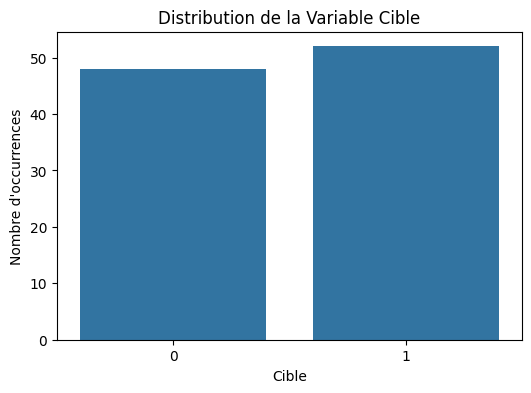

Le graphique montre le nombre d'occurrences pour chaque classe de la variable cible. Ceci est utile pour vérifier l'équilibre des classes.


In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x=df['target'])
plt.title('Distribution de la Variable Cible')
plt.xlabel('Cible')
plt.ylabel('Nombre d\'occurrences')
plt.show()
print("Le graphique montre le nombre d'occurrences pour chaque classe de la variable cible. Ceci est utile pour vérifier l'équilibre des classes.")

### Relation entre une Variable Catégorielle et la Cible

Analysons comment une variable catégorielle (par exemple, `cat_col1`) se rapporte à la variable cible. Cela peut aider à identifier des catégories spécifiques qui ont une probabilité plus élevée ou plus faible d'appartenir à une classe cible donnée.

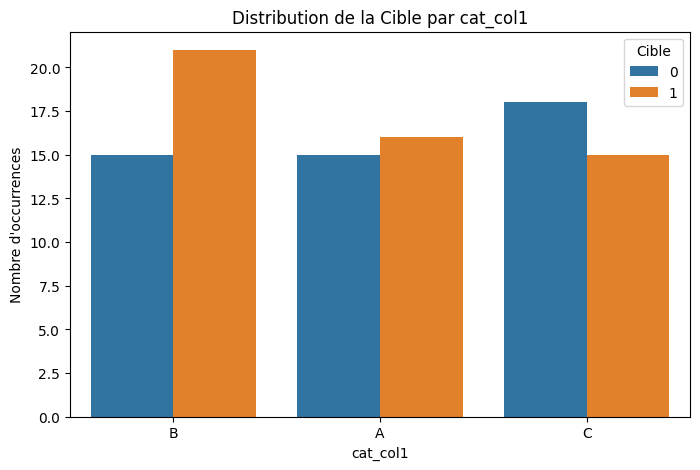

Ce graphique montre la distribution de la variable cible pour chaque catégorie de 'cat_col1'. Des différences notables entre les barres pour 'target=0' et 'target=1' par catégorie indiquent une relation potentielle.


In [11]:
if len(original_cat_cols) > 0:
    # Choisissons la première colonne catégorielle originale pour la visualisation
    selected_cat_col = original_cat_cols[0]
    plt.figure(figsize=(8,5))
    sns.countplot(data=df_for_categorical_eda, x=selected_cat_col, hue='target')
    plt.title(f'Distribution de la Cible par {selected_cat_col}')
    plt.xlabel(selected_cat_col)
    plt.ylabel('Nombre d\'occurrences')
    plt.legend(title='Cible')
    plt.show()
    print(f"Ce graphique montre la distribution de la variable cible pour chaque catégorie de '{selected_cat_col}'. Des différences notables entre les barres pour 'target=0' et 'target=1' par catégorie indiquent une relation potentielle.")
else:
    print("Aucune colonne catégorielle n'a été trouvée pour ce graphique.")

In [2]:
import pandas as pd
import numpy as np
import os

# Create a dummy data.csv file if it doesn't exist
if not os.path.exists('data.csv'):
    print("Creating dummy 'data.csv'...")
    data = {
        'num_col1': np.random.rand(100) * 100,
        'num_col2': np.random.randint(1, 50, 100),
        'cat_col1': np.random.choice(['A', 'B', 'C'], 100),
        'cat_col2': np.random.choice(['X', 'Y'], 100),
        'target': np.random.randint(0, 2, 100)
    }
    dummy_df = pd.DataFrame(data)
    dummy_df.to_csv('data.csv', index=False)
    print("Dummy 'data.csv' created successfully.")
else:
    print("'data.csv' already exists. Skipping dummy file creation.")

Creating dummy 'data.csv'...
Dummy 'data.csv' created successfully.
